## Programming Assignment - Bootstrap Methods - Adv. Econometrics 2

**Deadline**:  Friday 17:00 hours, 8 January 2021

|Nr|**Name**|**Student ID**|**Email**|
|--|--------|--------------|---------|
|1.|Dante van der Heijden|11020075|dantesean@gmail.com|
|2.|Wietse Steenstra|11004487|wietse161@live.nl|
|3.|Willem Kullberg|11041544|wkullberg@live.nl|

**Declaration of Originality**

We whose names are given under 1., 2. and 3. above declare that:

1. These solutions are solely our own work.
2. We have not made (part of) these solutions available to any other student.
3. We shall not engage in any other activities that will dishonestly improve my results or dishonestly improve or hurt the results of others.

## Instructions for completing and submitting the assignment
1. Submit your work in the form of (i) a Jupyter Notebook and (ii) PDF-file via Canvas assuming basic econometric knowledge, before the deadline. Your notebook should not give errors when executed with `Run All`.
2. Complete the table with the info of your group members. By submitting the Jupyter Notebook, you agree with the included declaration of originality. Do not copy work of others. This will be considered as fraud!
3. Clarify your code with comments.

## Hints
- Only use the paired bootstrap
- Work with Numpy vectors or matrices as much as possible, e.g. `np.quantile(tB_OLS,[0.05,0.95],axis=0)` returns two quantiles for the whole vector of OLS estimates
- When coding, you can reduce the running time by setting `BOOTREP=99` and reduce the number of simulations. For the final execution, please return to original values!
- For a progress bar, please install `conda install -c conda-forge tqdm` or if you don't use anaconda use can just execute `pip install tqdm`
- If you want to use plotly, please install `conda install -c plotly plotly`
- Below, you can find Python code for generating the data and doing a simulation using multicores. To use multicores, you have to install `multiprocess`: `conda install -c conda-forge multiprocess`. Otherwise, execute `pip install multiprocess`
- The idea behind multiprocess is that each CPU core receives a sample, executes the resampling and returns the results. These results will be stored in one big list, which can be analyzed after the simulation.

## Assignment 

The purpose of this assignment is for you to gain practical experience with resampling methods. You will investigate several bootstrap confidence intervals for OLS and LASSO estimators. The DGP is given by:

- $X_i \sim N(0,\Sigma)$, $\Sigma=(\sigma_{ij}) \in \mathbb{R}^{p\times p}$ with $\sigma_{ij}=\rho^{|i-j|}$, $\beta_j=0$ for $1\leq j\leq p-15$, $\beta_j=0.5$ for $p-14\leq j\leq p-10$, $\beta_j=1.5$ for $p-9\leq j \leq p-5$ $\beta_j=2.5$ for $p-4 \leq j \leq p$. 

- $\varepsilon_1,...,\varepsilon_n \sim N(0,1)$

- $y=X \beta+\varepsilon$

Let $\hat{\beta}=(X'X)^{-1}X'y$ denote the OLS estimator, while $\breve{\beta}$ denote the LASSO estimator based on minimizing
$$ \sum_{i=1}^{n} (y_i- b'X_i)^2+\alpha \sum_{j=1}^{p}|b_j|.$$
Only consider `lasso = linear_model.Lasso(alpha=0.02)`, so keep the amount of regularization fixed!

Please, briefly answer all questions below using graphs and if necessary tables.

## Import packages

In [1]:
import numpy as np
from sklearn import linear_model
# import plotly.express as px        # uncomment if you want to use plotly.express
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

## Generate Samples

In [2]:
REP = 1000                            # numer of Monte Carlo simulations
BOOTREP = 999                         # number of bootstrap replications SET BACK TO 999
n = 50
p = 25
rho = 0.6
mu = np.zeros(p)
Sigma = np.identity(p)
for i in range(p):
    for j in range(p):
        Sigma[i,j] = rho**abs(i - j)
beta = np.zeros(p)
beta[(p - 15):(p - 10)] = 0.5
beta[(p - 10):(p - 5)] = 1.5
beta[(p - 5):] = 2.5
arglist=[]
for r in tqdm(range(REP)):
    X = np.random.multivariate_normal(mean=mu, cov=Sigma, size=n)
    eps = np.random.normal(size=n)
    y = X@beta + eps
    arglist.append((r,BOOTREP,y,X))

  0%|          | 0/1000 [00:00<?, ?it/s]

## Resampling Procedure

In [3]:
def Bootstrap(args):
    (iter,BOOTREP,y,X)=args
    
    # Define OLS function
    def OLS(y,X):
        N,p = X.shape                   # number of observations and regressors
        XXi = np.linalg.inv(X.T @ X)
        b_ols = XXi @ (X.T @ y)
        res = y-X @ b_ols
        s2 = (res @ res)/(N-p)
        SE = np.sqrt(s2*np.diag(XXi))
        return b_ols,SE,res
    
    import numpy as np
    from sklearn import linear_model
    from scipy.stats import norm
    
    n,p = X.shape
    # Estimates original sample
    lasso = linear_model.Lasso(alpha=0.02)
    lasso.fit(X, y)
    b_LASSO=np.copy(lasso.coef_)
    b_OLS,b_OLS_SE,res = OLS(y,X)
    # initilize bootstrap arrays
    bB_LASSO = np.zeros((BOOTREP,p))
    bB_OLS   = np.zeros((BOOTREP,p))
    bB_OLS_SE = np.zeros((BOOTREP,p))
    tB = np.zeros((BOOTREP,p))

    np.random.seed(1)
    # balanced bootstap
    index_B=np.random.permutation(np.repeat(np.arange(n),BOOTREP)).reshape((BOOTREP,n))
    for b in range(BOOTREP):
        index = index_B[b,:]  # select the indices
        yB = np.copy(y[index])
        XB = np.copy(X[index,:])
        lasso.fit(XB, yB)
        bB_LASSO[b,:] = np.copy(lasso.coef_)
        bB_OLS[b,:], bB_OLS_SE[b,:], bres = OLS(yB, XB)
        tB[b, :] = (bB_OLS[b]-b_OLS)/bB_OLS_SE[b]
        
    se_boot_OLS = np.std(bB_OLS, axis=0)
    se_boot_LASSO = np.std(bB_LASSO, axis=0)
    
    # percentile
    q_bB_LASSO = np.quantile(bB_LASSO,[0.05,0.95],axis=0)
    q_bB_OLS   = np.quantile(bB_OLS,[0.05,0.95],axis=0)
    q_tB_OLS   = np.quantile(tB,[0.05,0.95],axis=0)
    
    ## Calc median bias
    perc_of_bootreps_smaller_than_b_LASSO = pd.DataFrame(bB_LASSO).lt(b_LASSO).sum()/BOOTREP
    z_0 = norm.ppf(perc_of_bootreps_smaller_than_b_LASSO)
    
    ## Calc acceleration coefficient
    
    # Jackknife
    jackknife_values=np.zeros((n,p))
    b_lasso_jack = np.zeros((n,p))
    for i in range(n):
        X_jack=np.delete(X,i,axis=0)
        y_jack = np.delete(y,i)
        lasso.fit(X_jack,y_jack)
        b_lasso_jack[i,:] = np.copy(lasso.coef_)
    avg_b_lasso_jack = np.mean(b_lasso_jack,axis=0)
    dev_b_lasso_jack = avg_b_lasso_jack - b_lasso_jack

    # Acceleration coefficient
    np.seterr(divide='ignore', invalid='ignore')
    acc_coefficient = (dev_b_lasso_jack**3).sum(axis=0) / (6*(dev_b_lasso_jack**2).sum(axis=0)**(1.5))
    
    # Set nans to zero. Zero is the 'default' acceleration value, so this shouldn't affect the results too much.
    acc_coefficient[np.isnan(acc_coefficient)] = 0
    
    ## Calc upper and lower quantiles
    alpha_1 = norm.cdf(z_0 + (z_0+norm.ppf(0.05))/(1-acc_coefficient*(z_0+norm.ppf(0.05))))
    alpha_2 = norm.cdf(z_0 + (z_0+norm.ppf(0.95))/(1-acc_coefficient*(z_0+norm.ppf(0.95))))
    
    
    ## Calc confidence interval
    bca_CI_LASSO = np.zeros((p,2))
    for i in range(p):
        b_LASSO_part = bB_LASSO[:,i]
        bca_CI_LASSO[i,:] = np.quantile(b_LASSO_part,[alpha_1[i],alpha_2[i]])

    argout = [b_LASSO,b_OLS, b_OLS_SE, se_boot_LASSO, se_boot_OLS, q_bB_LASSO, q_bB_OLS, q_tB_OLS, bca_CI_LASSO.T    # add more when necessary
             ]
    return(argout)

## Execute the Simulation and get Results

In [4]:
from multiprocess import Pool
pool4 = Pool(processes=4)
result_list = list(tqdm(pool4.imap_unordered(Bootstrap, arglist), total=REP))
pool4.close()
pool4.join()

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.723965812228478, tolerance: 0.4688942927078064
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5507447781718984, tolerance: 0.46273784077603364
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7385223068048354, tolerance: 0.2964386525029529
  positive)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1590

## Perform the Post-Processing

In [5]:
nr_methods=4                        # number of methods
                                    # 0 = percentile
                                    # 1 = SE_boot
                                    # 2 = percentile-t
                                    # 3 = BCa

# Initialize arrays
# Bootstrap regressors and SEs
b_LASSO    =np.zeros((REP,p))
b_OLS      =np.zeros((REP,p))
b_OLS_SE = np.zeros((REP,p))
se_boot_LASSO    =np.zeros((REP,p))
se_boot_OLS      =np.zeros((REP,p))

# Bootstrap upper and lower bounds for CIs
lb_boot_LASSO = np.zeros((REP,p))
ub_boot_LASSO = np.zeros((REP,p))
lb_boot_OLS = np.zeros((REP,p))
ub_boot_OLS = np.zeros((REP,p))
t_lb_boot_OLS = np.zeros((REP,p))
t_ub_boot_OLS = np.zeros((REP,p))

# BCA confidence interval
ub_bca_CI_lasso = np.zeros((REP,p))
lb_bca_CI_lasso = np.zeros((REP,p))

for r in tqdm(range(REP)):
    b_LASSO[r,:]  = result_list[r][0]
    b_OLS[r,:]    = result_list[r][1]
    b_OLS_SE[r,:] = result_list[r][2]
    se_boot_LASSO[r,:] = result_list[r][3]
    se_boot_OLS[r,:] = result_list[r][4]
    lb_boot_LASSO[r,:] = result_list[r][5][0]
    ub_boot_LASSO[r,:] = result_list[r][5][1]
    lb_boot_OLS[r,:] = result_list[r][6][0]
    ub_boot_OLS[r,:] = result_list[r][6][1]
    t_lb_boot_OLS[r,:] = result_list[r][7][0]
    t_ub_boot_OLS[r,:] = result_list[r][7][1]
    lb_bca_CI_lasso[r,:] = result_list[r][8][0]
    ub_bca_CI_lasso[r,:] = result_list[r][8][1]
    
percentile_t_lb = b_OLS - t_ub_boot_OLS*b_OLS_SE
percentile_t_ub = b_OLS - t_lb_boot_OLS*b_OLS_SE

  0%|          | 0/1000 [00:00<?, ?it/s]

1. Choose $n=50$, $p=25$ and $\rho=0.6$. Determine the bias and RMSE of the OLS and LASSO estimators using 1,000 Monte Carlo replications.

## Carry Out Analysis

Avg OLS bias = 0.00680218728197327, Avg Lasso bias = 0.010527453478031603
Avg OLS SE = 0.2930696059778897, Avg Lasso SE = 0.24405718282141742
Avg OLS RMSE = 0.2931957439639195, Avg Lasso RMSE = 0.24439071418479422


<AxesSubplot:>

<Figure size 7200x4800 with 0 Axes>

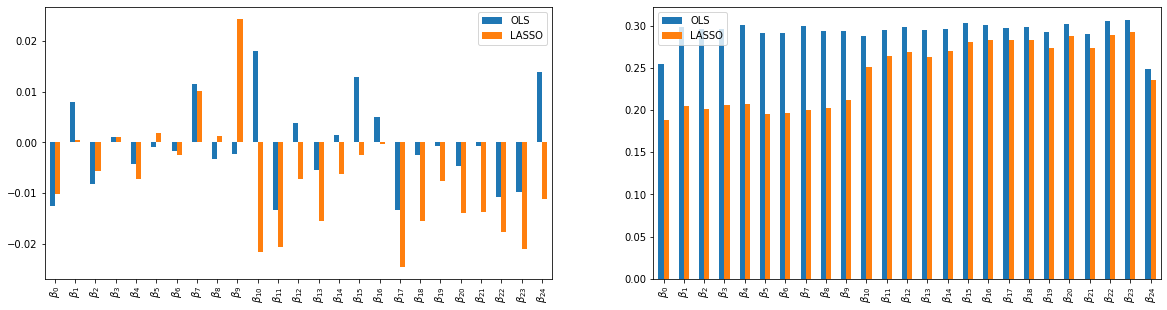

In [6]:
##### 1.
# Calculate bias for each regressor
MC_mean_OLS = np.mean(b_OLS, axis = 0)
MC_mean_LASSO = np.mean(b_LASSO, axis = 0)
MC_bias_OLS = MC_mean_OLS - beta
MC_bias_LASSO = MC_mean_LASSO - beta

# Calculate SE for each regressor
MC_SE_OLS = np.std(b_OLS, axis = 0)
MC_SE_LASSO = np.std(b_LASSO, axis = 0)

# Mean absolute bias
avg_bias_OLS = np.mean(abs(MC_bias_OLS))
avg_bias_LASSO = np.mean(abs(MC_bias_LASSO))

# Mean SE
avg_SE_OLS = np.mean(MC_SE_OLS)
avg_SE_LASSO = np.mean(MC_SE_LASSO)

RMSE_OLS = np.sqrt(np.mean((b_OLS - beta)**2, axis=0))
RMSE_LASSO = np.sqrt(np.mean((b_LASSO - beta)**2, axis=0))

print("Avg OLS bias = {0}, Avg Lasso bias = {1}".format(avg_bias_OLS,avg_bias_LASSO))
print("Avg OLS SE = {0}, Avg Lasso SE = {1}".format(avg_SE_OLS,avg_SE_LASSO))
print("Avg OLS RMSE = {0}, Avg Lasso RMSE = {1}".format(np.mean(RMSE_OLS), np.mean(RMSE_LASSO)))

# Create DFs for plots
q1_bias = pd.DataFrame({"OLS": MC_bias_OLS, "LASSO": MC_bias_LASSO})
q1_RMSE = pd.DataFrame({"OLS": RMSE_OLS, "LASSO": RMSE_LASSO})
indices = []
for i in range(len(q1_bias.index)):
    indices.append("$β_{" + str(i) + "}$")

q1_bias.index = indices
q1_RMSE.index = indices

# Plot figure
plt.figure(dpi=1200)

fig1, axes1 = plt.subplots(1, 2, figsize=(20,5))
q1_bias.plot.bar(ax=axes1[0])
q1_RMSE.plot.bar(ax=axes1[1])

**Answer:** We can see that the average bias is very low, thus the RMSE is mostly caused by the variance.

2. Estimate by simulation the coverage probabilities (cov. prob.) of the 90% first-order asymptotic two-sided confidence intervals for the OLS estimator, i.e. the fraction of confidence intervals (CI)
$$[\hat{\beta_j}-1.645 SE(\hat{\beta_j}),\hat{\beta_j}+1.645 SE(\hat{\beta_j})]$$
that contains the true parameter $\beta_j$. Here $SE(\hat{\beta_j})$ is the usual (non-robust) standard error based on $s^2(X'X)^{-1}$.

Average coverage probability = 0.8876


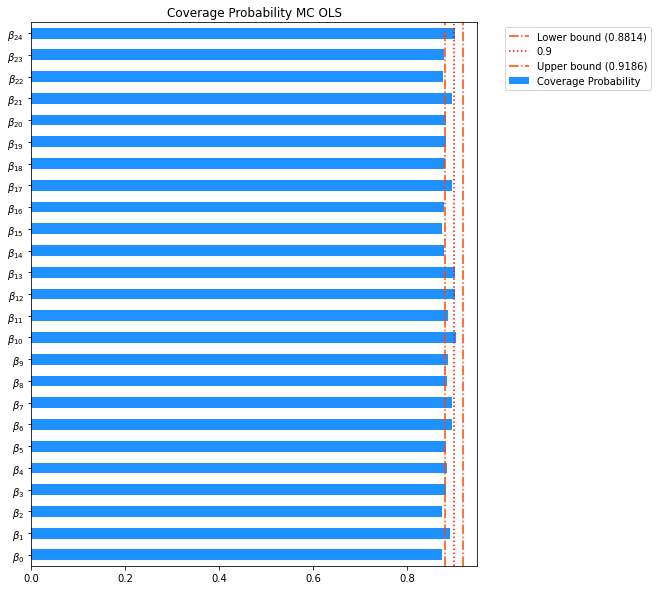

In [7]:
##### 2.

# Calculate bounds
mc_ols_lb = pd.DataFrame(b_OLS) - 1.645*b_OLS_SE
mc_ols_ub = pd.DataFrame(b_OLS) + 1.645*b_OLS_SE

# Compute betas within bounds and compute average
mc_ols_CI = mc_ols_lb.le(pd.Series(beta).T, axis=1) & mc_ols_ub.ge(pd.Series(beta).T, axis=1)
mc_ols_cov_avg_prob = np.mean(mc_ols_CI.sum()/REP)

print("Average coverage probability = {}".format(mc_ols_cov_avg_prob))

# Plot
q2_CI_conv = pd.DataFrame({"Coverage Probability": (mc_ols_CI.sum()/REP)})
q2_CI_conv.index = indices
fig2, axes2 = plt.subplots(1, 1, figsize=(8,10))
(q2_CI_conv).plot.barh(ax=axes2, label="Coverage Probability", color="dodgerblue")
axes2.title.set_text("Coverage Probability MC OLS")
axes2.axvline(x=0.8814, color='orangered', ls='-.', label='Lower bound (0.8814)')
axes2.axvline(x=0.9, color='red', ls=':', label='0.9')
axes2.axvline(x=0.9186, color='orangered', ls='-.', label='Upper bound (0.9186)')
axes2.legend(bbox_to_anchor=(1.05,1))

**Answer:** Most coverage probabilities are close to, but slightly lower than 0.9. So in less than 90\% of the cases, the CI contains the true $\beta$.

3. Estimate by simulation the cov. prob. of the 90% first-order asymptotic two-sided CI for OLS and LASSO using $$SE_{boot}(\tilde{\beta}),$$
for $$\tilde{\beta}\in \{\hat{\beta},\breve{\beta}\}.$$

Average coverage probability OLS = 0.9987999999999999
Average coverage probability LASSO = 0.9541999999999998


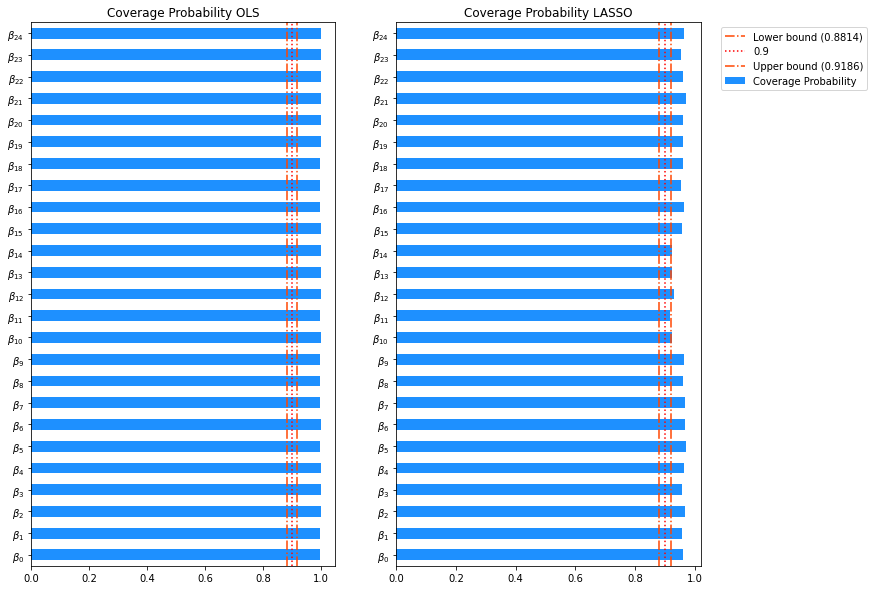

In [8]:
##### 3.

# Calculate bootstrap bounds for OLS and Lasso
boot_ols_lb = pd.DataFrame(b_OLS) - 1.645*se_boot_OLS
boot_ols_ub = pd.DataFrame(b_OLS) + 1.645*se_boot_OLS
boot_lasso_lb = pd.DataFrame(b_LASSO) - 1.645*se_boot_LASSO
boot_lasso_ub = pd.DataFrame(b_LASSO) + 1.645*se_boot_LASSO

# Compute betas within bounds and compute average
boot_ols_CI = boot_ols_lb.le(pd.Series(beta).T, axis=1) & boot_ols_ub.ge(pd.Series(beta).T, axis=1)
boot_ols_cov_avg_prob = np.mean(boot_ols_CI.sum()/REP)
boot_lasso_CI = boot_lasso_lb.le(pd.Series(beta).T, axis=1) & boot_lasso_ub.ge(pd.Series(beta).T, axis=1)
boot_lasso_cov_avg_prob = np.mean(boot_lasso_CI.sum()/REP)

print("Average coverage probability OLS = {}".format(boot_ols_cov_avg_prob))
print("Average coverage probability LASSO = {}".format(boot_lasso_cov_avg_prob))

# Plots
q3_CI_conv_OLS = pd.DataFrame({"Coverage Probability": (boot_ols_CI.sum()/REP)})
q3_CI_conv_LASSO = pd.DataFrame({"Coverage Probability": (boot_lasso_CI.sum()/REP)})
q3_CI_conv_OLS.index = indices
q3_CI_conv_LASSO.index = indices
fig3, axes3 = plt.subplots(1, 2, figsize=(12,10))
(q3_CI_conv_OLS).plot.barh(ax=axes3[0], label="Coverage Probability", color="dodgerblue")
axes3[0].title.set_text("Coverage Probability OLS")
axes3[0].axvline(x=0.8814, color='orangered', ls='-.', label='Lower bound (0.8814)')
axes3[0].axvline(x=0.9, color='red', ls=':', label='0.9')
axes3[0].axvline(x=0.9186, color='orangered', ls='-.', label='Upper bound (0.9186)')
axes3[0].get_legend().remove()
(q3_CI_conv_LASSO).plot.barh(ax=axes3[1], label="Coverage Probability", color="dodgerblue")
axes3[1].title.set_text("Coverage Probability LASSO")
axes3[1].axvline(x=0.8814, color='orangered', ls='-.', label='Lower bound (0.8814)')
axes3[1].axvline(x=0.9, color='red', ls=':', label='0.9')
axes3[1].axvline(x=0.9186, color='orangered', ls='-.', label='Upper bound (0.9186)')
axes3[1].legend(bbox_to_anchor=(1.05,1))

**Answer:** Both for OLS and LASSO with bootstrapped SE, the coverage probability is significantly higher than 0.9 and for OLS even close to 1. This indicates that in almost all cases the CI includes the true parameter and this could indicate underrejection. It is remarkable that in the case of LASSO, the coverage probabilities for the betas for which $\beta_i = 0.5$ are closer to 0.9 than the others. 

4. Note that the cov. prob. can be interpreted as the number of successes in 1,000 trials. Hence, the estimated cov. prob. is not significantly different (at the 95% confidence level) from 90% if its value is contained in the interval
$$0.90\pm 1.96\sqrt{(0.90\times 0.10/1000)}=[0.8814,0.9186].$$
Check if the estimated cov. prob. of questions 2 & 3 are significantly different from 90%. What is your conclusion?

**Answer:** As can ben seen in the figures above, all coverage probabilities for question 2 are within the interval of $[0.8814, 0.9186]$, thus they are not significantly different from 90%. This can also be seen in the table below. 

For question 3, with OLS all coverage probabilities are fairly higher than 0.9 and they significantly differ from it. This means that almost always the true beta is contained in the confidence interval. 
Never rejecting $H_0$ while it is true isn't a bad thing by itself, but with a limited sample this might suggest that the power of the test is low. In other words, this could indicate underrejection. If the test is specified to have a certain alpha (type I error) we want to maximize the power for this given alpha and not have a lower alpha with low power. When the amount of observations is increased, this problem disappears and we see that the coverage probabilities actually go towards 0.9.

For most parameters of the bootstrapped LASSO coverage probabilities, we also have coverage probabilities outside the given interval. This indicates the same problem as with OLS, but to a slightly smaller decree. The difference between OLS and LASSO could be explained that they both tend to overfit (since we have 25 variables and only 50 observations), but LASSO penalized parameters and thus overfits less than OLS. 

So, in this case, the bootstrapped SE does not perform better than the usual SE.

In [9]:
table_1 = pd.DataFrame({"Coverage Probability Q2": (mc_ols_CI.sum()/REP), "Coverage Probability Q3 OLS": (boot_ols_CI.sum()/REP), "Coverage Probability Q3 LASSO": (boot_lasso_CI.sum()/REP)})
table_1.index = indices
display(table_1)

,Coverage Probability Q2,Coverage Probability Q3 OLS,Coverage Probability Q3 LASSO
$β_{0}$,0.875,0.998,0.962
$β_{1}$,0.891,0.998,0.957
$β_{2}$,0.875,0.999,0.966
$β_{3}$,0.883,0.999,0.958
$β_{4}$,0.885,0.999,0.964
$β_{5}$,0.884,0.998,0.970
$β_{6}$,0.897,1.000,0.966
$β_{7}$,0.895,0.998,0.967
$β_{8}$,0.886,0.996,0.960
$β_{9}$,0.887,0.998,0.963


5. Estimate by simulation the cov. prob. for OLS and LASSO of 90% equal-tailed two-sided percentile bootstrap confidence intervals:
$$(\tilde{\beta}_{95\%}^*,\tilde{\beta}_{5\%}^*),$$
where $\mathbb{P}_*[\tilde{\beta}^*>\beta_{5\%}^*]=5\%$ and  $\tilde{\beta}\in \{\hat{\beta},\breve{\beta}\}$.

Average coverage probability of OLS = 0.9942
Average coverage probability LASSO = 0.9765599999999999


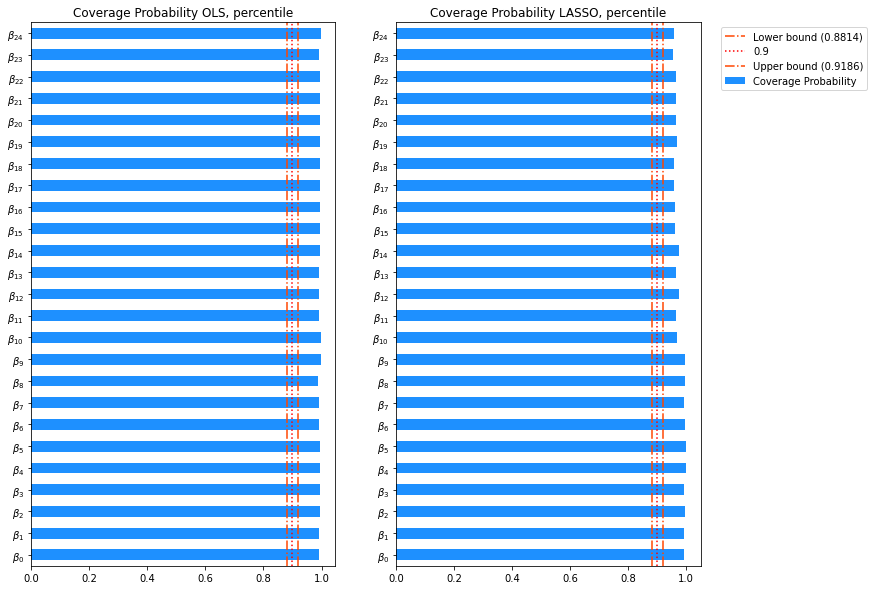

In [10]:
##### 5. 

# Create confidence intervals based on bootstrap
boot_ols_CI = pd.DataFrame(lb_boot_OLS).le(pd.Series(beta).T, axis=1) & pd.DataFrame(ub_boot_OLS).ge(pd.Series(beta).T, axis=1)
boot_lasso_CI = pd.DataFrame(lb_boot_LASSO).le(pd.Series(beta).T, axis=1) & pd.DataFrame(ub_boot_LASSO).ge(pd.Series(beta).T, axis=1)

# Calculate coverage probabalities
boot_ols_cov_avg_prob = np.mean(boot_ols_CI.sum()/REP)
boot_lasso_cov_avg_prob = np.mean(boot_lasso_CI.sum()/REP)

print("Average coverage probability of OLS = {}".format(boot_ols_cov_avg_prob))
print("Average coverage probability LASSO = {}".format(boot_lasso_cov_avg_prob))

# Plots
q5_CI_conv_OLS = pd.DataFrame({"Coverage Probability": (boot_ols_CI.sum()/REP)})
q5_CI_conv_LASSO = pd.DataFrame({"Coverage Probability": (boot_lasso_CI.sum()/REP)})
q5_CI_conv_OLS.index = indices
q5_CI_conv_LASSO.index = indices
fig4, axes4 = plt.subplots(1, 2, figsize=(12,10))
(q5_CI_conv_OLS).plot.barh(ax=axes4[0], label="Coverage Probability, percentile", color="dodgerblue")
axes4[0].title.set_text("Coverage Probability OLS, percentile")
axes4[0].axvline(x=0.8814, color='orangered', ls='-.', label='Lower bound (0.8814)')
axes4[0].axvline(x=0.9, color='red', ls=':', label='0.9')
axes4[0].axvline(x=0.9186, color='orangered', ls='-.', label='Upper bound (0.9186)')
axes4[0].get_legend().remove()
(q5_CI_conv_LASSO).plot.barh(ax=axes4[1], label="Coverage Probability", color="dodgerblue")
axes4[1].title.set_text("Coverage Probability LASSO, percentile")
axes4[1].axvline(x=0.8814, color='orangered', ls='-.', label='Lower bound (0.8814)')
axes4[1].axvline(x=0.9, color='red', ls=':', label='0.9')
axes4[1].axvline(x=0.9186, color='orangered', ls='-.', label='Upper bound (0.9186)')
axes4[1].legend(bbox_to_anchor=(1.05,1))

**Answer:** Again, all coverage probabilities are close to 1. It is remarkable that all OLS coverage probabilities are very close to 1, and for LASSO the coverage probabilities for the first 10 parameters are very close to 1. These parameters are actually 0 and thus less likely to be constrained by the LASSO penalty. 
######## TOCH? Weet dit niet zeker dus als 't niet klopt gewoon eruit halen ########

6.  Estimate by simulation the cov. prob. for OLS of 90% equal-tailed two-sided percentile-$t$ bootstrap confidence intervals based on the quantiles of the root
$$(\hat{\beta}^*-\hat{\beta})/SE(\hat{\beta}^*),$$ 
where $SE(\hat{\beta}^*)$ is based on $s^{*2}(X^{*}\,' X^{*})^{-1}$.

Average coverage probability of OLS = 0.99712


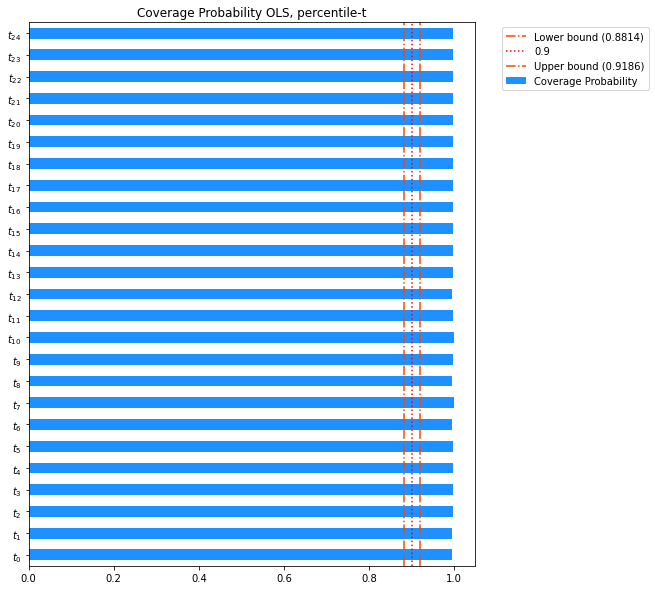

In [11]:
# Create confidence intervals based on bootstrap
t_boot_ols_CI = pd.DataFrame(percentile_t_lb).le(pd.Series(beta).T, axis=1) & pd.DataFrame(percentile_t_ub).ge(pd.Series(beta).T, axis=1)

# Calculate coverage probabalities
t_boot_ols_cov_avg_prob = np.mean(t_boot_ols_CI.sum()/REP)

print("Average coverage probability of OLS = {}".format(t_boot_ols_cov_avg_prob))

# Plot
q6_CI_conv = pd.DataFrame({"Coverage Probability": (t_boot_ols_CI.sum()/REP)})
indices = []
for i in range(len(q6_CI_conv.index)):
    indices.append("$t_{" + str(i) + "}$")
q6_CI_conv.index = indices
fig5, axes5 = plt.subplots(1, 1, figsize=(8,10))
(q6_CI_conv).plot.barh(ax=axes5, label="Coverage Probability, percentile-t", color="dodgerblue")
axes5.title.set_text("Coverage Probability OLS, percentile-t")
axes5.axvline(x=0.8814, color='orangered', ls='-.', label='Lower bound (0.8814)')
axes5.axvline(x=0.9, color='red', ls=':', label='0.9')
axes5.axvline(x=0.9186, color='orangered', ls='-.', label='Upper bound (0.9186)')
axes5.legend(bbox_to_anchor=(1.05,1))

**Answer**: It is clear that nearly all coverage probabilities of the bootstrap approach 1. This may perhaps be due to overfitting.

7. What problems would you encounter if you wanted to implement the percentile-$t$ intervals for the LASSO? How could you remedy these problems (you don't have to implement this)?

**Answer:** For the LASSO this cannot be calculated. A suggestion to solve this is to iterate the bootstrap, leading to the nested bootstrap. With this, we can calculate t-values. ######## Wat zei die nou precies hierover? Kan nog niet terugkijken. Misschien kan dit antwoord iets verbeterd worden ########

8.  Estimate by simulation the cov. prob. for LASSO of 90% two-sided bias-corrected and accelerated (BC$_a$) confidence intervals. For this, use the bootstrap to estimate the (median) bias and the Jackknife for the acceleration constant. In the BC$_a$ method, the quantiles are adjusted:
$$\alpha_1=\Phi\left ( \hat{z}_0+\frac{\hat{z}_0+z_{\alpha/2}}{1-\hat{a}(\hat{z}_0+z_{\alpha/2})} \right ), \\
  \alpha_2=\Phi\left ( \hat{z}_0+\frac{\hat{z}_0+z_{1-\alpha}}{1-\hat{a}(\hat{z}_0+z_{1-\alpha/2})} \right ) \\
$$
with $z_{0.95}=1.645$. Here
$$\hat{z}_0=\Phi^{-1}\left ( \frac{\sum_{i=1}^n \mathbb{1} \{\hat{\theta}^*(b)<\hat{\theta}\}}{B} \right)$$
and
$$ \hat{a}=\frac{\sum_{i=1}^n (\hat{\theta}_{(\cdot)}-\hat{\theta}_{(i)})^3}{6\{\sum_{i=1}^n(\hat{\theta}_{(\cdot)}-\hat{\theta}_{(i)})^2\}^{3/2}}$$
with $\hat{\theta}_{(\cdot)}=\sum_{i=1}^n \hat{\theta}_{(i)}/n$; see for more details Section 14.3 of Efron, B., & Tibshirani, R. J. (1994). An introduction to the bootstrap: [link](http://www.ru.ac.bd/stat/wp-content/uploads/sites/25/2019/03/501_02_Efron_Introduction-to-the-Bootstrap.pdf)).

Average coverage probability bias-corrected and accelerated = 0.9377599999999999


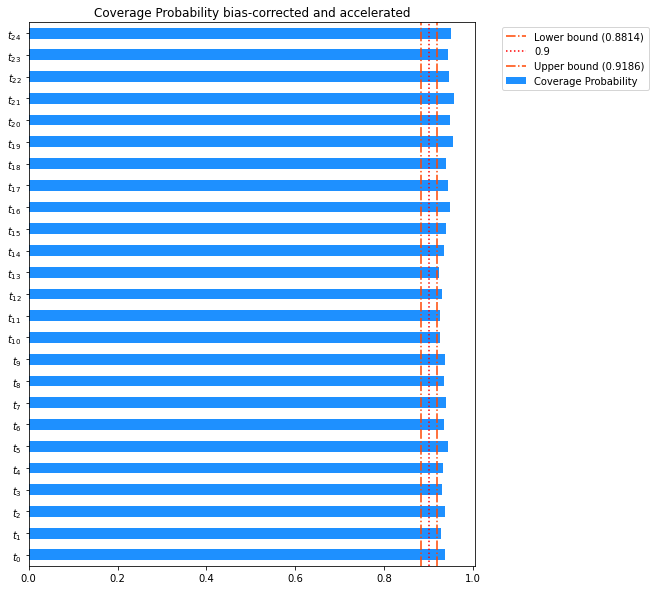

In [12]:
# Create confidence intervals based on bootstrap
bca_lasso_CI = pd.DataFrame(lb_bca_CI_lasso).le(pd.Series(beta).T, axis=1) & pd.DataFrame(ub_bca_CI_lasso).ge(pd.Series(beta).T, axis=1)

# Calculate coverage probabalities
boot_lasso_cov_avg_prob = np.mean(bca_lasso_CI.sum()/REP)

print("Average coverage probability bias-corrected and accelerated = {}".format(boot_lasso_cov_avg_prob))

# Plot
q8_CI_conv = pd.DataFrame({"Coverage Probability": (bca_lasso_CI.sum()/REP)})
indices = []
for i in range(len(q8_CI_conv.index)):
    indices.append("$t_{" + str(i) + "}$")
q8_CI_conv.index = indices
fig6, axes6 = plt.subplots(1, 1, figsize=(8,10))
(q8_CI_conv).plot.barh(ax=axes6, label="Coverage Probability", color="dodgerblue")
axes6.title.set_text("Coverage Probability bias-corrected and accelerated")
axes6.axvline(x=0.8814, color='orangered', ls='-.', label='Lower bound (0.8814)')
axes6.axvline(x=0.9, color='red', ls=':', label='0.9')
axes6.axvline(x=0.9186, color='orangered', ls='-.', label='Upper bound (0.9186)')
axes6.legend(bbox_to_anchor=(1.05,1))

**Answer:** Again, we can see that for most t-values, the coverage probability is sigfinicantly higher than 0.9. For some though, it is still within the given bounds. 

9. Based on all the results of this assignment, which inference procedure would you advise a practitioner that wants to conduct inference in a model described by the DGP? Motivate your recommendation.

**Answer:** From the coverage probabilities, we can see that in this small-sample environment, we likely have overfitting of the data. Bootstrapping does generally not improve the coverage probabilities here. 

For LASSO, we generally cannot produce meaningful confidence intervals. Thus, it could still be useful to perform the bootstrap principle because that way, we can form confidence intervals and draw conclusions. 

The last solution, with bias-corrected and accelerated confidence intervals, is the 'best of the worst' performers and could be used to conduct inference. 

However, this is a fairly complicated method and to stay in line with the general idea that simpler is better, the usual OLS confidence intervals are favored. It is to be expected that this performs well, because the assumptions required are satisfied in the model.